<a href="https://colab.research.google.com/github/abhi99-ut/aih/blob/feature%2Fself_learning/AIH_SL_MLipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery

# Set your project ID here
project_id = "xxxx-xxxx"
client = bigquery.Client(project=project_id)

In [ ]:
query = """
SELECT *
FROM `xxxx-xxxx.mimic_data_prep.all_patients_outcome_notes`
"""

In [ ]:
#run query
df = client.query(query).to_dataframe()

In [ ]:
heart_disease_codes = [
    '410', '411', '412', '413', '414',  # Ischemic heart disease
    '428',  # Heart failure
    '427',  # Arrhythmias
    '424',  # Valvular disorders
    '425',  # Cardiomyopathy
    '426',  # Conduction disorders
    '402'   # Hypertensive heart disease
]
renal_disease_codes = [
    '580', '581', '582', '583', '584', '585', '586', '587', '588'
]


# Filter the DataFrame
df['is_heart_disease'] = df['ICD9_CODE'].apply(lambda x: any(str(x).startswith(code) for code in heart_disease_codes))
df['is_renal_disease'] = df['ICD9_CODE'].apply(lambda x: any(str(x).startswith(code) for code in renal_disease_codes))


### EDA

In [ ]:
df.groupby(['OUTCOME','is_heart_disease']).size().sort_values(ascending=False)

,,0
OUTCOME,is_heart_disease,
Favorable,False,25735
Intermediate_Care,False,11301
Favorable,True,7240
Adverse,False,5502
Other,False,3934
Intermediate_Care,True,2880
Unknown,False,1132
Adverse,True,724
Other,True,333


In [ ]:
cols_to_sel = ['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'SHORT_TITLE', 'GENDER', 'DOB',
'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ADMITTIME', 'DISCHTIME',
'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'OUTCOME',
'cleaned_radiology_notes',
'cleaned_ecg_notes', 'cleaned_nursing_other_notes',
'cleaned_nursing_notes', 'cleaned_physician_notes']

In [ ]:
df = df[df['ADMISSION_TYPE']!='NEWBORN'].reset_index(drop=True)
df['OUTCOME'] = df['OUTCOME'].replace('Unknown', 'Other')

In [ ]:
df.OUTCOME.value_counts()

,count
OUTCOME,
Favorable,26203
Intermediate_Care,14175
Adverse,6162
Other,4526


In [ ]:
df = df[df.is_heart_disease==1].reset_index(drop=True)

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,SHORT_TITLE,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,OUTCOME,combined_case_management_notes,combined_consult_notes,combined_ecg_notes,combined_echo_notes,combined_general_notes,combined_nursing_notes,combined_nutrition_notes,combined_nursing_other_notes,combined_physician_notes,combined_radiology_notes,combined_rehab_notes,combined_respiratory_notes,combined_social_work_notes,combined_pharmacy_notes,is_heart_disease,is_renal_disease
0,73686,120933,42731,Atrial fibrillation,F,2056-02-21,NaT,NaT,NaT,0,2121-09-05 23:50:00,2121-09-15 14:01:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,2121-09-05 21:52:00,2121-09-06 01:15:00,PNEUMONIA,0,1,Intermediate_Care,None,None,Atrial fibrillation. Borderline left ventricu...,None,None,None,None,None,None,[**2121-9-5**] 10:15 PM\n CT HEAD W/O CONTRAST...,None,None,None,None,True,False
1,57036,162444,42789,Cardiac dysrhythmias NEC,F,2106-03-17,2192-10-21,NaT,2192-10-21,1,2191-03-01 17:38:00,2191-03-02 11:00:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,JEWISH,WIDOWED,WHITE,2191-03-01 13:02:00,2191-03-01 18:40:00,HYPOTENSION,0,1,Intermediate_Care,None,None,Normal sinus rhythm with atrio-ventricular con...,PATIENT/TEST INFORMATION:\nIndication: hypoten...,None,None,None,None,None,[**2191-3-1**] 4:00 PM\n CTA CHEST W&W/O C&REC...,None,None,None,None,True,False
2,70476,118218,42843,Ac/chr syst/dia hrt fail,M,2051-09-30,2133-06-27,2133-06-27,2133-06-27,1,2133-05-14 18:54:00,2133-05-23 18:34:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,ICF,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,2133-05-14 16:25:00,2133-05-14 21:40:00,PNEUMONIA,0,1,Intermediate_Care,None,None,Atrial fibrillation with a rapid ventricular r...,None,None,None,None,None,None,"[**Last Name (LF) **],[**First Name3 (LF) 1783...",None,None,None,None,True,False
3,29530,115144,4240,Mitral valve disorder,F,2026-01-20,2102-09-30,2102-09-30,2102-09-30,1,2102-04-13 08:00:00,2102-04-17 14:57:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,NaT,NaT,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,0,1,Intermediate_Care,None,None,Probable accelerated junctional rhythm with ST...,PATIENT/TEST INFORMATION:\nIndication: Intra-o...,None,None,None,"Neuro: A&O x3, forgetful @ times, need constan...",None,[**2102-4-13**] 1:34 PM\n CHEST PORT. LINE PLA...,None,None,None,None,True,False
4,97770,159554,4240,Mitral valve disorder,M,2050-01-07,NaT,NaT,NaT,0,2107-06-14 07:15:00,2107-06-21 15:30:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Private,ENGL,OTHER,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,Intermediate_Care,None,None,Sinus rhythm. Within normal limits. Compared...,PATIENT/TEST INFORMATION:\nIndication: MVR/CAB...,None,None,None,None,None,[**2107-6-14**] 1:19 PM\n CHEST PORT. LINE PLA...,None,None,None,None,True,False


In [ ]:
df.to_csv('heart_disease_data.csv', index=False)

In [ ]:
cols_to_sel = ['SUBJECT_ID', 'HADM_ID', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION','MARITAL_STATUS', 'ETHNICITY', 'OUTCOME']

In [ ]:
df = df[cols_to_sel].copy()

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,OUTCOME
0,73686,120933,F,2056-02-21,2121-09-05 23:50:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,Intermediate_Care
1,57036,162444,F,2106-03-17,2191-03-01 17:38:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,JEWISH,WIDOWED,WHITE,Intermediate_Care
2,70476,118218,M,2051-09-30,2133-05-14 18:54:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,Intermediate_Care
3,29530,115144,F,2026-01-20,2102-04-13 08:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,Intermediate_Care
4,97770,159554,M,2050-01-07,2107-06-14 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,ENGL,OTHER,MARRIED,WHITE,Intermediate_Care


In [ ]:
df['AGE']= (df.ADMITTIME-df.DOB).dt.days//365

In [ ]:
df['ETHNICITY'].value_counts()

,count
ETHNICITY,
WHITE,7938
UNKNOWN/NOT SPECIFIED,1650
BLACK/AFRICAN AMERICAN,551
UNABLE TO OBTAIN,249
OTHER,212
HISPANIC OR LATINO,195
PATIENT DECLINED TO ANSWER,135
ASIAN,101
WHITE - RUSSIAN,41


In [ ]:
# Replace specific patterns in the ETHNICITY column
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)

# Use .loc to ensure the assignment is done correctly without chained assignment warning
top_ethnicities = df['ETHNICITY'].value_counts().nlargest(5).index.tolist()
df.loc[~df['ETHNICITY'].isin(top_ethnicities), 'ETHNICITY'] = 'OTHER/UNKNOWN'


<ipython-input-80-a572b73c494e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-80-a572b73c494e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [ ]:

df['ETHNICITY'].value_counts()

,count
ETHNICITY,
WHITE,8014
OTHER/UNKNOWN,2288
BLACK/AFRICAN AMERICAN,594
HISPANIC/LATINO,257
ASIAN,172


In [ ]:
df.loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE']), 'RELIGION'] = 'RELIGIOUS'


In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,OUTCOME,AGE
0,73686,120933,F,2056-02-21,2121-09-05 23:50:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,RELIGIOUS,DIVORCED,WHITE,Intermediate_Care,65
1,57036,162444,F,2106-03-17,2191-03-01 17:38:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,RELIGIOUS,WIDOWED,WHITE,Intermediate_Care,85
2,70476,118218,M,2051-09-30,2133-05-14 18:54:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,Intermediate_Care,81
3,29530,115144,F,2026-01-20,2102-04-13 08:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,ENGL,RELIGIOUS,SINGLE,WHITE,Intermediate_Care,76
4,97770,159554,M,2050-01-07,2107-06-14 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,ENGL,RELIGIOUS,MARRIED,WHITE,Intermediate_Care,57


In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'OUTCOME', 'AGE'],
      dtype='object')

## Experiment

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Encode categorical columns
le = LabelEncoder()
for col in ['GENDER', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']:
    df[col] = le.fit_transform(df[col])



# Target encoding
df['OUTCOME'] = le.fit_transform(df['OUTCOME'])

# Split data
X = df[['GENDER','ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'AGE']]

#X = df.drop('OUTCOME', axis=1)
y = df['OUTCOME']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Evaluate the model (basic evaluation)
accuracy = xgb_model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.69


In [ ]:
accuracy = xgb_model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.69


## Results

Classification Report:
                   precision    recall  f1-score   support

          Adverse       0.20      0.03      0.05       137
        Favorable       0.74      0.89      0.81      1456
Intermediate_Care       0.52      0.45      0.48       574
            Other       0.14      0.01      0.02        98

         accuracy                           0.69      2265
        macro avg       0.40      0.34      0.34      2265
     weighted avg       0.63      0.69      0.64      2265



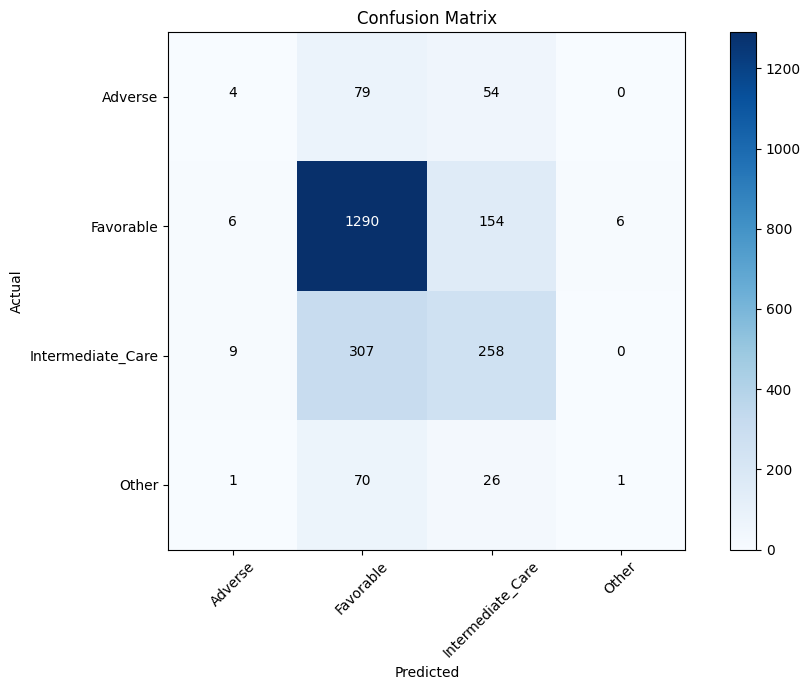

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions (ensure your model and test data are ready)
y_pred = xgb_model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define the class labels
class_labels = ['Adverse', 'Favorable', 'Intermediate_Care', 'Other']  # Modify this based on your classes

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add tick marks and labels
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add annotations inside the confusion matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()

# Print the classification report with class labels
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

plt.show()


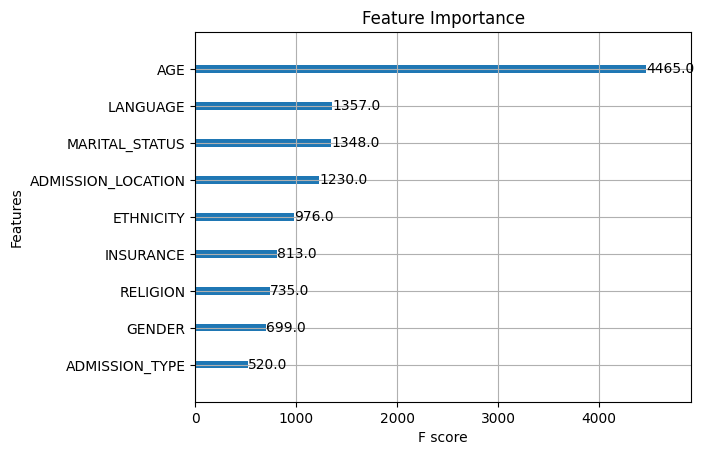

In [ ]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()
